In [3]:
# Note, this requires cloning the facenet_pytorch repo
from facenet_pytorch import MTCNN
import numpy as np
import cv2
import matplotlib.pyplot as plt

def detect_face(img):
    mtcnn = MTCNN(keep_all=True, device=device)
    return mtcnn.detect(img)

def mask_face(img, x1, x2, y1, y2):
    h,w, _ = img.shape
    mask = np.zeros((h, w), dtype=np.uint8)
    mask[y1:y2,x1:x2] = 1 #np.random.rand(y2-y1, x2-x1, 3) * 255
    masked_image = img.copy()
    masked_image[y1:y2,x1:x2] = 1
    return mask, masked_image

def mask_detected_faces(input_face_path='CS445-Object-Inpainting/data_faces/joe_face_small.jpeg'):
    frame = cv2.cvtColor(cv2.imread(input_face_path), cv2.COLOR_BGR2RGB)
    print(frame.shape)
    boxes, confidence = detect_face(frame)

    masked = frame.copy()

    for i, detected in enumerate(boxes):
        if confidence[i] < .5:
            continue

        [x1, y1, x2, y2] = detected
        
        # adjust mask smaller so face replacement has more to work with
        x_adj = abs(x2-x1) / 8
        y_adj = abs(y2-y1) / 8
        x1 = int(x1 + x_adj)
        x2 = int(x2 - x_adj)
        y1 = int(y1 + y_adj)
        y2 = int(y2 - y_adj)
        
        mask, masked_image = mask_face(masked, x1, x2, y1, y2)     
    plt.imshow(masked_image)
    plt.show()
    return frame, mask

In [4]:
import torch
from utils.models import GatedGenerator, Generator, Discriminator

def load_checkpoint(generator, discriminator_local, discriminator_global, path, device):
    state = torch.load(path,map_location=device)
    generator.load_state_dict(state['G'])
    discriminator_global.load_state_dict(state['D_G'])
    discriminator_local.load_state_dict(state['D_L'])
    print('Loaded checkpoint successfully')
    return generator, discriminator_local, discriminator_global



In [5]:
device = 'cuda:2'
generator = GatedGenerator()
discriminator_global = Discriminator(in_channels=3)
discriminator_local = Discriminator(in_channels=3)

generator = generator.to(device)
discriminator_global = discriminator_global.to(device)
discriminator_local = discriminator_local.to(device)

In [13]:
generator, discriminator_local, discriminator_global = load_checkpoint(generator, discriminator_local, discriminator_global, "/home/x1112373/CS445-Object-Inpainting/model_trained/model_1.pth", device)

Loaded checkpoint successfully


In [14]:
generator.eval()

GatedGenerator(
  (coarse): Sequential(
    (0): GatedConv2d(
      (pad): ZeroPad2d((3, 3, 3, 3))
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
      (mask_conv2d): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1))
      (sigmoid): Sigmoid()
    )
    (1): GatedConv2d(
      (pad): ZeroPad2d((1, 1, 1, 1))
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (mask_conv2d): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (sigmoid): Sigmoid()
    )
    (2): GatedConv2d(
      (pad): ZeroPad2d((1, 1, 1, 1))
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2d): Conv2d(128, 256, kernel_size=(3, 3)

(467, 350, 3)


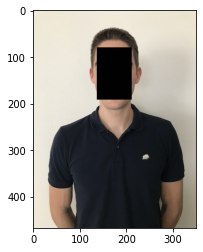

(467, 350, 3)


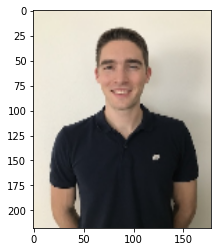

In [15]:
from torchvision.transforms import ToTensor
frame, masked = mask_detected_faces()
def return_image_numpy(images, scale=False):
    if scale:
        completed_images_np = images[0].cpu().detach().numpy()
 
        completed_images_np = ((completed_images_np + 1) * 127.5)
        print(completed_images_np.shape)
        return completed_images_np.transpose(1, 2, 0)
    else:
        return images[0].detach().cpu().numpy().transpose(1, 2, 0)

print(frame.shape)
# Transpose the image to change the channel order from (218, 178, 3) to (3, 218, 178)
transposed_image = frame.transpose(2, 0, 1)
# Resize the transposed image to the desired dimensions (3, 128, 128)
resized_image = []
for channel in transposed_image:
    resized_channel = cv2.resize(channel, (128, 128))
    resized_image.append(resized_channel)
    
frame = np.array(resized_image)
masked = cv2.resize(masked, (128, 128))
frame = torch.from_numpy(frame).unsqueeze(0) 
masked = torch.tensor(masked, dtype=torch.float32).unsqueeze(0).unsqueeze(0) 

#prepare fore inference
frame = frame.to(device)
masked = masked.to(device)
first_out, second_out  = generator(frame[0], masked)
first_out_wholeimg = frame/255 * (1 - masked/255) + first_out * masked/255     
second_out_wholeimg = frame/255 * (1 - masked/255) + second_out * masked/255
resized_final_image = []
for channel in second_out_wholeimg[0]:
    resized_channel = cv2.resize(channel.detach().cpu().numpy(), (178, 218))
    resized_final_image.append(resized_channel)
resized_final_image = np.array(resized_final_image)    
plt.imshow(resized_final_image.transpose(1,2,0))

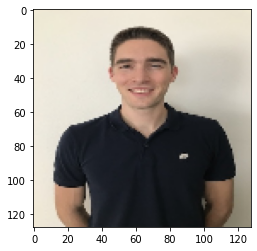

In [16]:
 
plt.imshow(return_image_numpy(second_out_wholeimg))